In [1]:
import numpy as np

In [2]:
def sum_squared_error(y, t):
    return .5*np.sum((y-t)**2)

交差エントロピー誤差

In [3]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [4]:
import os
from dataset.mnist import load_mnist

In [5]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [6]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 0からtrain_sizeまでの数字をbatch_sizeだけ抜き出し
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]


バッチデータ対応版交差エントロピー誤差

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(t * np.log(1 + 1e-7)) / batch_size


In [13]:
def numerical_gradient(f: "function", x: np.array, h = 1e-4) -> np.array:
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val

    return grad


In [14]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x

NNへの数値微分での実装

In [16]:
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # initialize weight with normal distribution.

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [17]:
from common import functions
from common.gradient import numerical_gradient

In [20]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = functions.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = functions.sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        dz1 = np.dot(dy, W2.T)
        da1 = functions.sigmoid_grad(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist


# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09915, 0.1009
train acc, test acc | 0.7766333333333333, 0.7841
train acc, test acc | 0.8746166666666667, 0.8788
train acc, test acc | 0.89695, 0.902
train acc, test acc | 0.9074166666666666, 0.9102
train acc, test acc | 0.91445, 0.9169
train acc, test acc | 0.9189833333333334, 0.9212
train acc, test acc | 0.9248, 0.9264
train acc, test acc | 0.928, 0.9302
train acc, test acc | 0.9311, 0.9325
train acc, test acc | 0.93425, 0.9348
train acc, test acc | 0.9372333333333334, 0.9396
train acc, test acc | 0.93985, 0.9393
train acc, test acc | 0.9413166666666667, 0.9419
train acc, test acc | 0.9445166666666667, 0.9445
train acc, test acc | 0.9467666666666666, 0.9468
train acc, test acc | 0.9477833333333333, 0.9476


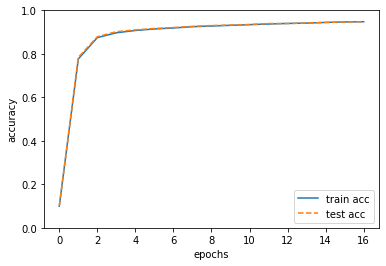

In [22]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

In [27]:
def tanh_derivative(x):
    y = 4/ (np.exp(x) + np.exp(-x)) ** 2
    return y

In [28]:
class ThreeLayerNet:

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden1_size)
        self.params['b1'] = np.zeros(hidden1_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden1_size, hidden2_size)
        self.params['b2'] = np.zeros(hidden2_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden2_size, output_size)
        self.params['b3'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
    
        a1 = np.dot(x, W1) + b1
        z1 = np.tanh(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = np.tanh(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        
        return y

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2, W3 = self.params['W1'], self.params['W2'], self.params['W3']
        b1, b2, b3 = self.params['b1'], self.params['b2'], self.params['b3']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = np.tanh(a1)
        a2 = np.dot(z1, W2) + b2
        z2 = np.tanh(a2)
        a3 = np.dot(z2, W3) + b3
        y = softmax(a3)
        
        # backward
        dy = (y - t) / batch_num
        grads['W3'] = np.dot(z2.T, dy)
        grads['b3'] = np.sum(dy, axis=0)
        
        dz2 = np.dot(dy, W3.T)
        da2 = tanh_derivative(a2) * dz2
        grads['W2'] = np.dot(z1.T, da2)
        grads['b2'] = np.sum(da2, axis=0)
        
        dz1 = np.dot(da2, W2.T)
        da1 = tanh_derivative(a1) * dz1
        grads['W1'] = np.dot(x.T, da1)
        grads['b1'] = np.sum(da1, axis=0)

        return grads

In [29]:
threelayernetwork = ThreeLayerNet(input_size=784, hidden1_size=100, hidden2_size=50, output_size=10)

iters_num = 10000  # 繰り返しの回数を適宜設定する
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配の計算
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = threelayernetwork.gradient(x_batch, t_batch)
    
    # パラメータの更新
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        threelayernetwork.params[key] -= learning_rate * grad[key]
    
    loss = threelayernetwork.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        train_acc = threelayernetwork.accuracy(x_train, t_train)
        test_acc = threelayernetwork.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.049933333333333337, 0.0503
train acc, test acc | 0.8400166666666666, 0.8399
train acc, test acc | 0.9057166666666666, 0.9051
train acc, test acc | 0.9314833333333333, 0.9313
train acc, test acc | 0.9467, 0.9451
train acc, test acc | 0.9564833333333334, 0.9532
train acc, test acc | 0.96345, 0.9583
train acc, test acc | 0.9659166666666666, 0.9591
train acc, test acc | 0.9716666666666667, 0.965
train acc, test acc | 0.97625, 0.9669
train acc, test acc | 0.9786, 0.9711
train acc, test acc | 0.9776333333333334, 0.9689
train acc, test acc | 0.98115, 0.9728
train acc, test acc | 0.98285, 0.9711
train acc, test acc | 0.9846833333333334, 0.9743
train acc, test acc | 0.9850333333333333, 0.9732
train acc, test acc | 0.98675, 0.9754


活性化関数がsigmoidのままでは3層にすると学習進まない  
→勾配消失のせい？  
->活性化関数をtanhにすると学習進む．精度向上．  


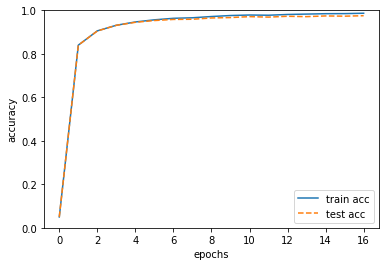

In [30]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()